# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.3.0


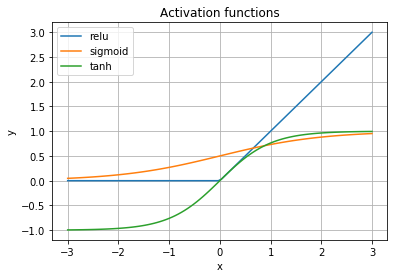

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [11]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    #pass

    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    PATH_TO_DATA = 'data/cifar-10-batches-py/'
    all_data = []
    all_labels = []
    for bIdx in range(1, 6):
        fname = PATH_TO_DATA + 'data_batch_%d' %bIdx
        data, labels = unpickle(fname)
        data = data.reshape(data.shape[0], 3, 32, 32).transpose(0,2,3,1).astype('float')
        labels = np.array(labels)
        all_data.append(data)
        all_labels.append(labels)
    data_train = np.concatenate(all_data)
    labels_train = np.concatenate(all_labels)
    del data, labels
    data_val = data_train[range(num_training, num_training+num_validation)]
    labels_val = labels_train[range(num_training, num_training+num_validation)]
    data_train = data_train[range(num_training)]
    labels_train = labels_train[range(num_training)]
    return data_train, labels_train, data_val, labels_val
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    #pass

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    PATH_TO_DATA = 'data/cifar-10-batches-py/'
    fname = PATH_TO_DATA + 'test_batch'
    data, labels = unpickle(fname)
    data_test = data.reshape(data.shape[0], 3, 32, 32).transpose(0,2,3,1).astype('float')
    labels_test = np.array(labels)
    return data_test, labels_test
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [17]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def fully_connected(input, num_inputs, num_outputs):
    W = tf.get_variable('W_fc', [num_inputs, num_outputs], tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b_fc', [num_outputs], initializer=tf.constant_initializer(0.0))
    return tf.matmul(input, W) + b
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [34]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        conv2_shape = self.pool2.get_shape()
        self.flat = tf.reshape(self.pool2, [-1, 4096])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_connected(self.flat, 4096, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_connected(self.relu3, 384, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_training = tf.placeholder(tf.bool)
        self.keep_prob = None
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        learning_rate = tf.train.exponential_decay(5e-4, self.global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=self.global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X: X_, self.Y: Y_, self.is_training: True}
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: Iteration, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            plt.plot(losses, '-o')
            plt.xlabel('Iteration')

            # Graph 2. X: Iteration, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Training accuracy')
            plt.plot(accuracies, '-o', label='Training')
            plt.xlabel('Iteration')
            plt.gcf().set_size_inches(15, 12)
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = feed_dict = {self.X: X_, self.Y: Y_, self.is_training: False}           
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 6.028, accuracy = 0.109
iteration (50): loss = 1.807, accuracy = 0.406
iteration (100): loss = 1.644, accuracy = 0.414
iteration (150): loss = 1.567, accuracy = 0.414
iteration (200): loss = 1.463, accuracy = 0.438
iteration (250): loss = 1.504, accuracy = 0.438
iteration (300): loss = 1.272, accuracy = 0.547
iteration (350): loss = 1.405, accuracy = 0.523


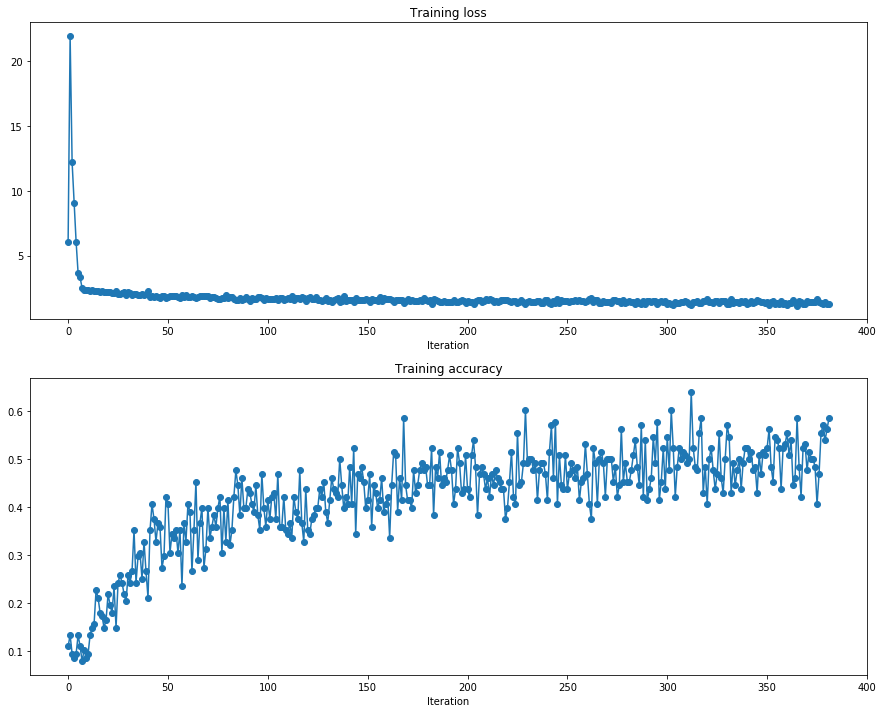

validation for epoch 0
-  epoch 0: validation accuracy = 0.555
train for epoch 1
iteration (400): loss = 1.282, accuracy = 0.555
iteration (450): loss = 1.327, accuracy = 0.523
iteration (500): loss = 1.323, accuracy = 0.477
iteration (550): loss = 1.034, accuracy = 0.633
iteration (600): loss = 1.265, accuracy = 0.531
iteration (650): loss = 1.285, accuracy = 0.578
iteration (700): loss = 1.228, accuracy = 0.516
iteration (750): loss = 1.002, accuracy = 0.633


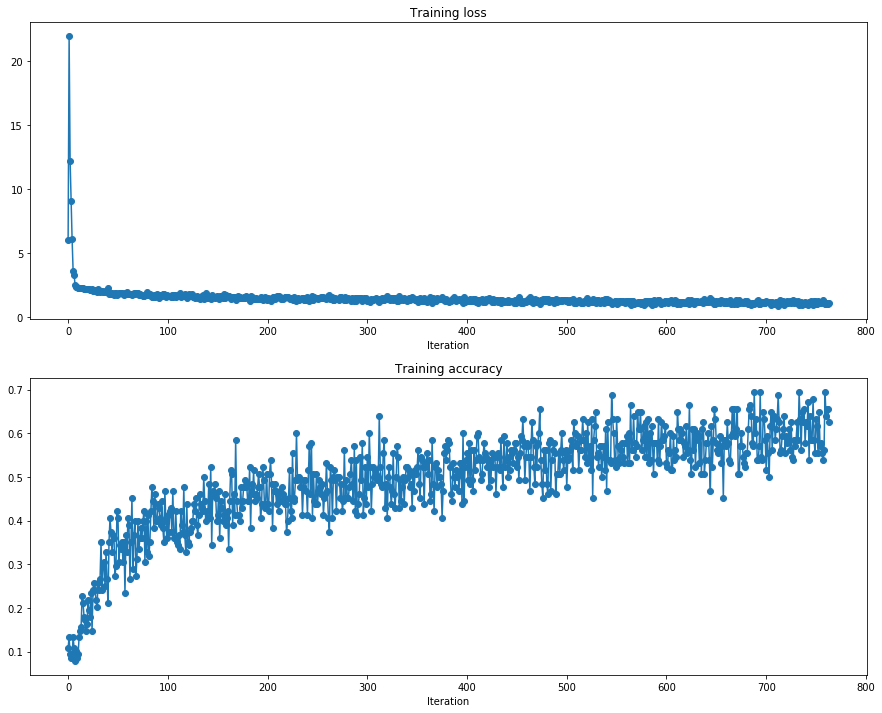

validation for epoch 1
-  epoch 1: validation accuracy = 0.606
train for epoch 2
iteration (800): loss = 0.938, accuracy = 0.594
iteration (850): loss = 1.188, accuracy = 0.531
iteration (900): loss = 0.997, accuracy = 0.648
iteration (950): loss = 0.881, accuracy = 0.672
iteration (1000): loss = 0.940, accuracy = 0.664
iteration (1050): loss = 0.943, accuracy = 0.664
iteration (1100): loss = 0.849, accuracy = 0.680


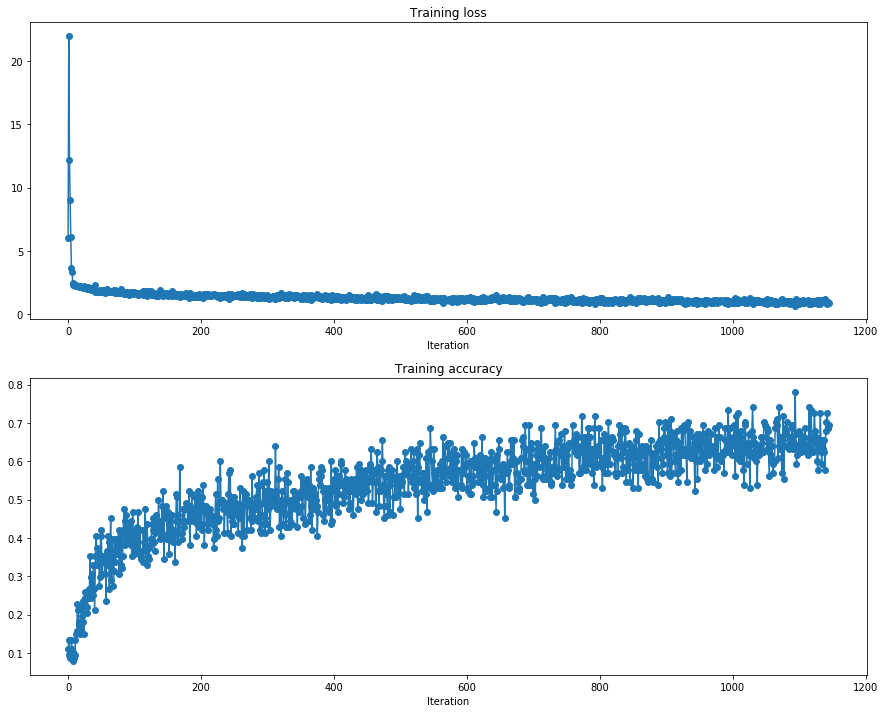

validation for epoch 2
-  epoch 2: validation accuracy = 0.642
train for epoch 3
iteration (1150): loss = 0.920, accuracy = 0.680
iteration (1200): loss = 0.840, accuracy = 0.711
iteration (1250): loss = 0.960, accuracy = 0.680
iteration (1300): loss = 1.102, accuracy = 0.562
iteration (1350): loss = 0.868, accuracy = 0.727
iteration (1400): loss = 0.949, accuracy = 0.688
iteration (1450): loss = 0.891, accuracy = 0.688
iteration (1500): loss = 0.685, accuracy = 0.766


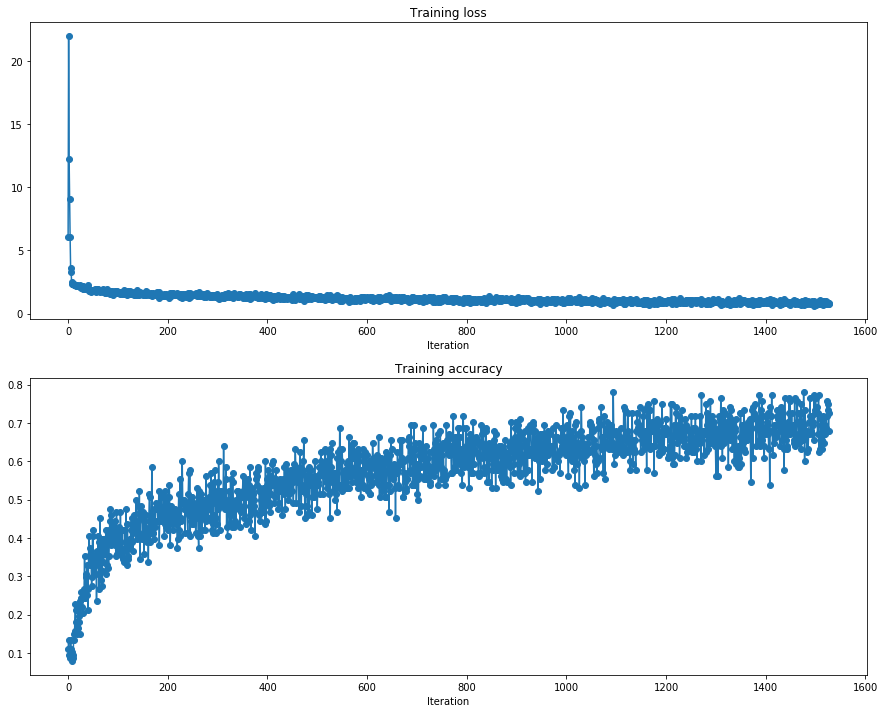

validation for epoch 3
-  epoch 3: validation accuracy = 0.653
train for epoch 4
iteration (1550): loss = 0.700, accuracy = 0.812
iteration (1600): loss = 0.892, accuracy = 0.641
iteration (1650): loss = 0.971, accuracy = 0.648
iteration (1700): loss = 0.779, accuracy = 0.711
iteration (1750): loss = 0.853, accuracy = 0.734
iteration (1800): loss = 0.749, accuracy = 0.742
iteration (1850): loss = 0.740, accuracy = 0.719
iteration (1900): loss = 0.799, accuracy = 0.703


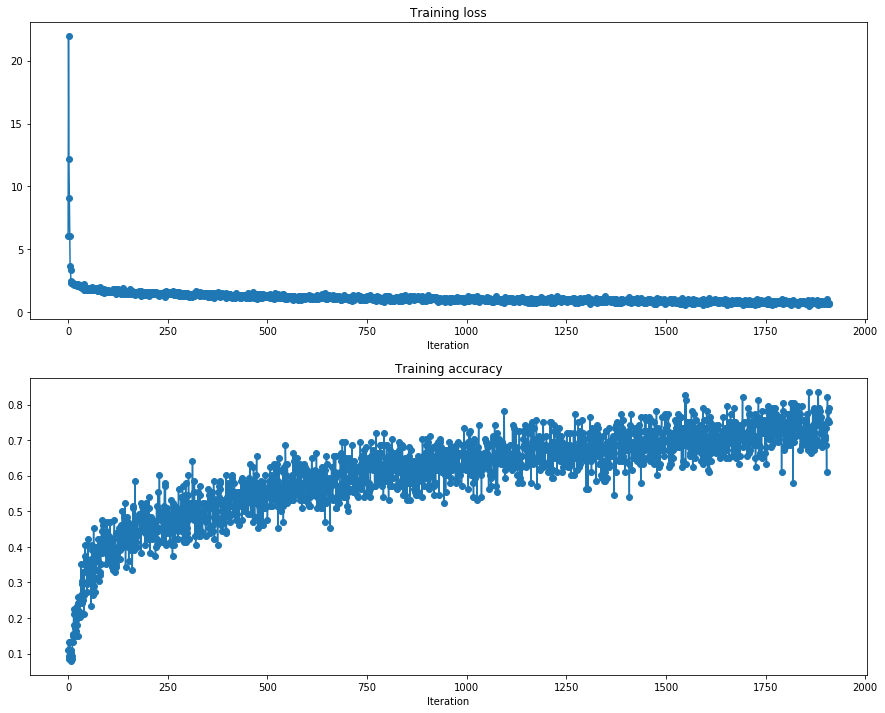

validation for epoch 4
-  epoch 4: validation accuracy = 0.655
***** test accuracy: 0.646
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [29]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [61]:
import tensorflow.contrib.layers as layers
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 30

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)

        #############################################################################
        # TODO: Implement you own model here                                        #
        #############################################################################
        print('intput layer: ' + str(self.X.get_shape()))
        
        # conv(32,3) + relu + pool(2) + batch norm + dropout(p=0.75)
        self.conv1 = layers.conv2d(self.X, 32, 3, activation_fn=tf.nn.relu)
        self.pool1 = layers.max_pool2d(self.conv1, 2, padding='SAME')
        self.bn1 = layers.batch_norm(self.pool1, updates_collections=None, is_training=self.is_training)
        self.dp1 = layers.dropout(self.bn1, keep_prob=0.75, is_training=self.is_training)
        print('scope 1: ' + str(self.dp1.get_shape()))
        
        # conv(64,3) + conv(64,3) + relu + pool(2) + batch norm + dropout(p=0.5)
        #self.conv2 = layers.conv2d(self.dp1, 64, 3, activation_fn=None, weights_initializer=layers.xavier_initializer(uniform=False))
        self.conv2 = layers.conv2d(self.dp1, 64, 3, activation_fn=None)
        self.conv3 = layers.conv2d(self.conv2, 64, 3, activation_fn=tf.nn.relu)
        self.pool2 = layers.max_pool2d(self.conv3, 2, padding='SAME')
        self.bn2 = layers.batch_norm(self.pool2, updates_collections=None, is_training=self.is_training)
        self.dp2 = layers.dropout(self.bn2, keep_prob=0.5, is_training=self.is_training)
        print('scope 2: ' + str(self.dp2.get_shape()))
        
        # flatten layer
        self.flat = layers.flatten(self.dp2)
        print('flat layer: ' + str(self.flat.get_shape()))
        
        # fc(output=512) + relu() + dropout(keep_prob = 0.5)
        self.fc3 = layers.fully_connected(self.flat, num_outputs=512, activation_fn=tf.nn.relu)
        self.dp3 = layers.dropout(self.fc3, keep_prob=0.5, is_training=self.is_training)
        print('scope 3: ' + str(self.dp3.get_shape()))
        
        # fc(output=10)
        self.fc4 = layers.fully_connected(self.dp3, num_outputs=10, activation_fn=None)
        print('scope 4: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################
    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        learning_rate = tf.train.exponential_decay(1e-3, self.global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=self.global_step)
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

-----  Your model  -----
intput layer: (?, 32, 32, 3)
scope 1: (?, 16, 16, 32)
scope 2: (?, 8, 8, 64)
flat layer: (?, 4096)
scope 3: (?, 512)
scope 4: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 4.594, accuracy = 0.125
iteration (50): loss = 1.850, accuracy = 0.297
iteration (100): loss = 1.649, accuracy = 0.352
iteration (150): loss = 1.548, accuracy = 0.375
iteration (200): loss = 1.646, accuracy = 0.375
iteration (250): loss = 1.573, accuracy = 0.406
iteration (300): loss = 1.551, accuracy = 0.477
iteration (350): loss = 1.399, accuracy = 0.484


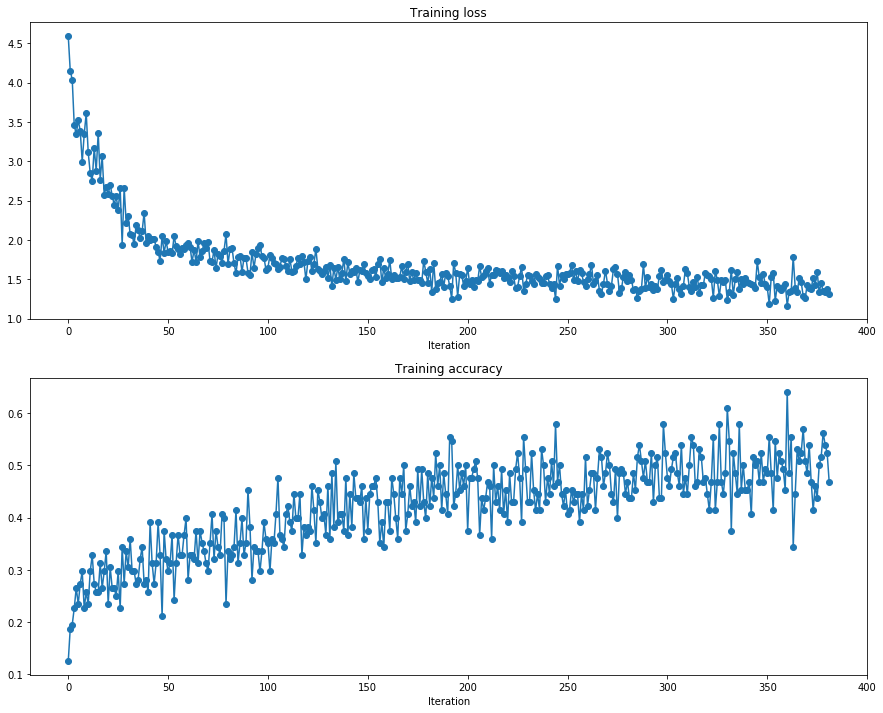

validation for epoch 0
-  epoch 0: validation accuracy = 0.335
train for epoch 1
iteration (400): loss = 1.222, accuracy = 0.539
iteration (450): loss = 1.363, accuracy = 0.531
iteration (500): loss = 1.302, accuracy = 0.516
iteration (550): loss = 1.289, accuracy = 0.531
iteration (600): loss = 1.159, accuracy = 0.562
iteration (650): loss = 1.392, accuracy = 0.516
iteration (700): loss = 1.153, accuracy = 0.570
iteration (750): loss = 1.186, accuracy = 0.555


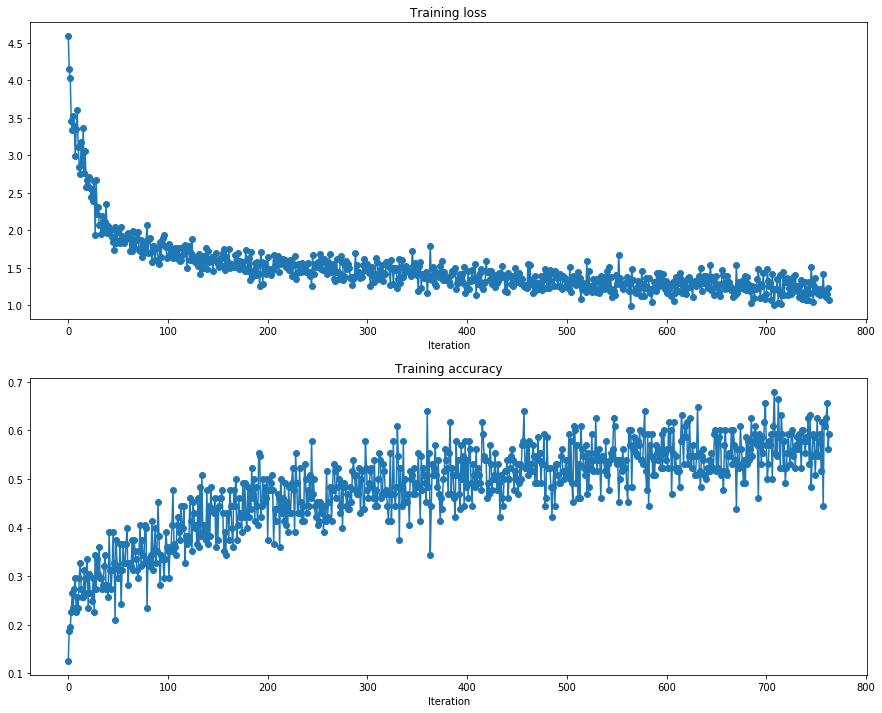

validation for epoch 1
-  epoch 1: validation accuracy = 0.490
train for epoch 2
iteration (800): loss = 1.084, accuracy = 0.586
iteration (850): loss = 1.267, accuracy = 0.586
iteration (900): loss = 1.007, accuracy = 0.680
iteration (950): loss = 1.033, accuracy = 0.656
iteration (1000): loss = 0.897, accuracy = 0.680
iteration (1050): loss = 1.195, accuracy = 0.555
iteration (1100): loss = 1.108, accuracy = 0.594


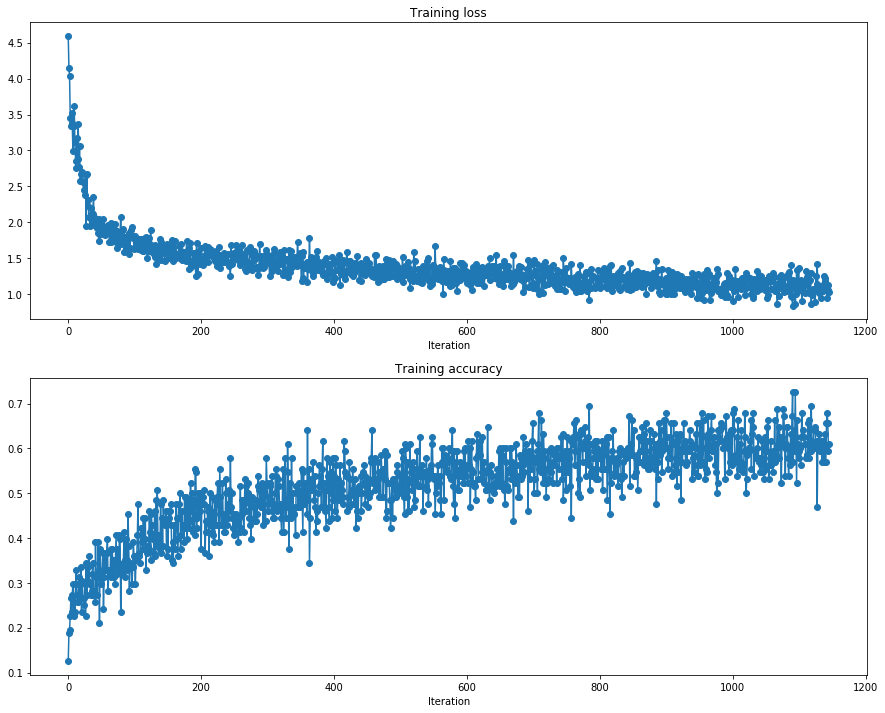

validation for epoch 2
-  epoch 2: validation accuracy = 0.509
train for epoch 3
iteration (1150): loss = 0.964, accuracy = 0.641
iteration (1200): loss = 0.899, accuracy = 0.688
iteration (1250): loss = 1.032, accuracy = 0.633
iteration (1300): loss = 1.213, accuracy = 0.562
iteration (1350): loss = 0.916, accuracy = 0.688
iteration (1400): loss = 1.062, accuracy = 0.641
iteration (1450): loss = 1.100, accuracy = 0.602
iteration (1500): loss = 0.728, accuracy = 0.805


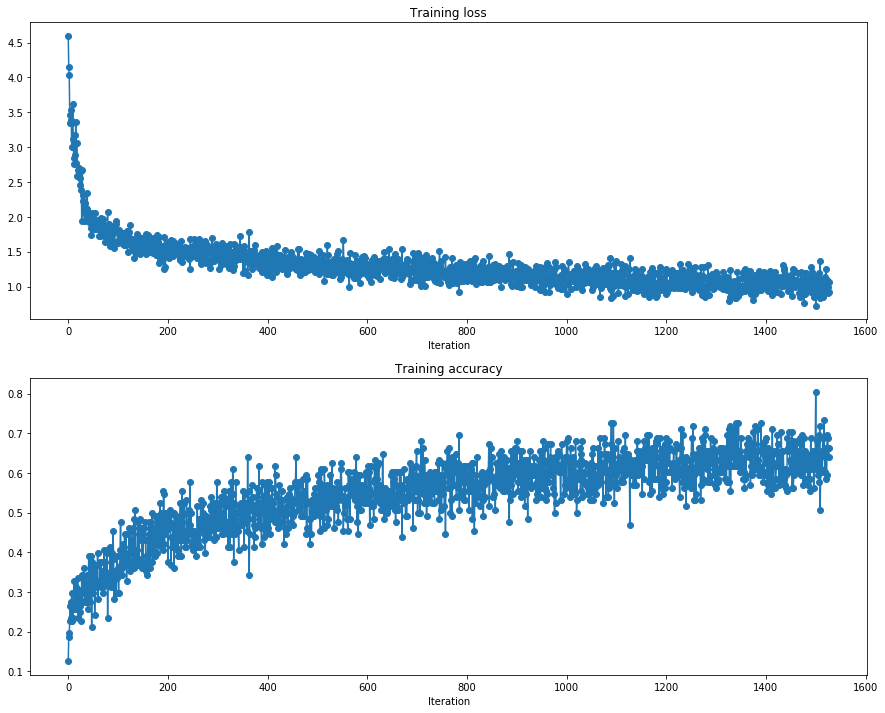

validation for epoch 3
-  epoch 3: validation accuracy = 0.616
train for epoch 4
iteration (1550): loss = 0.900, accuracy = 0.648
iteration (1600): loss = 1.074, accuracy = 0.609
iteration (1650): loss = 1.063, accuracy = 0.656
iteration (1700): loss = 0.943, accuracy = 0.656
iteration (1750): loss = 1.018, accuracy = 0.641
iteration (1800): loss = 0.830, accuracy = 0.711
iteration (1850): loss = 1.061, accuracy = 0.602
iteration (1900): loss = 0.965, accuracy = 0.664


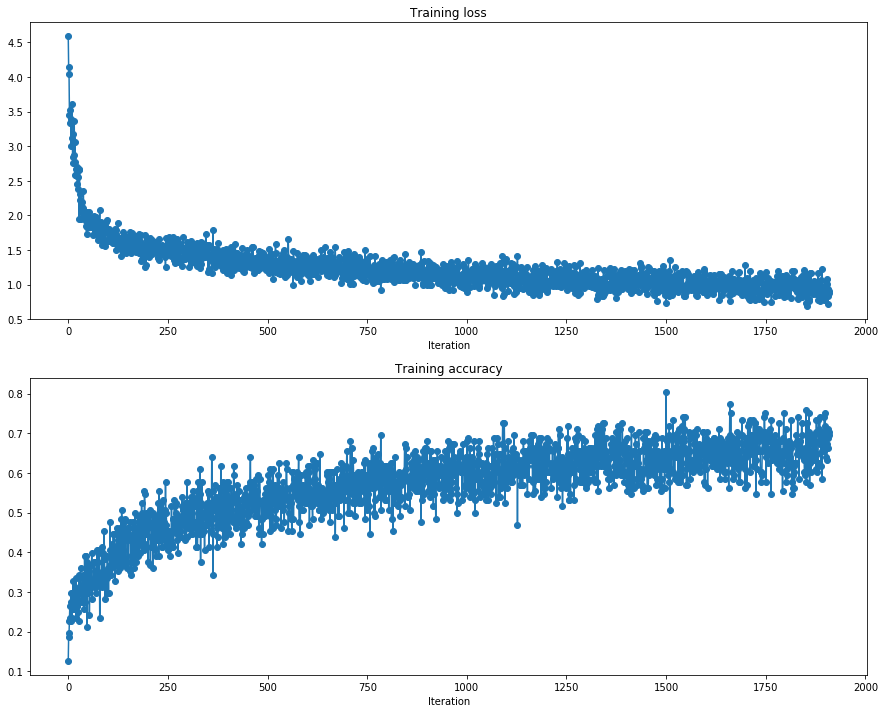

validation for epoch 4
-  epoch 4: validation accuracy = 0.662
train for epoch 5
iteration (1950): loss = 0.946, accuracy = 0.672
iteration (2000): loss = 0.886, accuracy = 0.695
iteration (2050): loss = 1.067, accuracy = 0.617
iteration (2100): loss = 0.982, accuracy = 0.672
iteration (2150): loss = 1.081, accuracy = 0.672
iteration (2200): loss = 1.153, accuracy = 0.617
iteration (2250): loss = 0.899, accuracy = 0.680


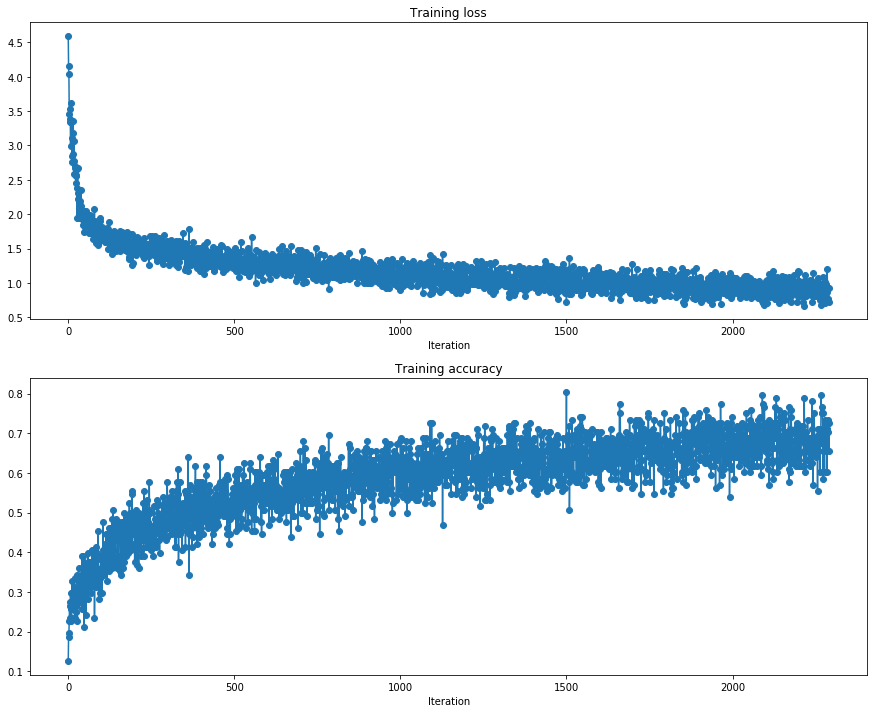

validation for epoch 5
-  epoch 5: validation accuracy = 0.662
train for epoch 6
iteration (2300): loss = 0.840, accuracy = 0.734
iteration (2350): loss = 0.826, accuracy = 0.703
iteration (2400): loss = 0.901, accuracy = 0.656
iteration (2450): loss = 0.952, accuracy = 0.672
iteration (2500): loss = 0.975, accuracy = 0.672
iteration (2550): loss = 0.846, accuracy = 0.703
iteration (2600): loss = 0.772, accuracy = 0.727
iteration (2650): loss = 0.812, accuracy = 0.734


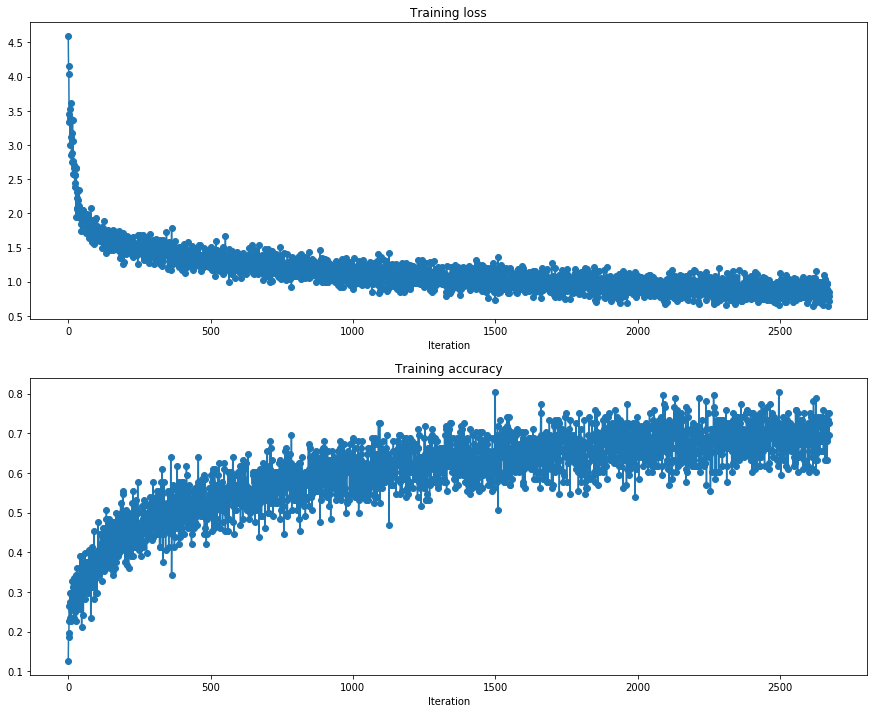

validation for epoch 6
-  epoch 6: validation accuracy = 0.696
train for epoch 7
iteration (2700): loss = 0.911, accuracy = 0.688
iteration (2750): loss = 0.941, accuracy = 0.641
iteration (2800): loss = 0.704, accuracy = 0.758
iteration (2850): loss = 0.814, accuracy = 0.734
iteration (2900): loss = 0.705, accuracy = 0.781
iteration (2950): loss = 0.827, accuracy = 0.742
iteration (3000): loss = 0.682, accuracy = 0.773
iteration (3050): loss = 0.773, accuracy = 0.688


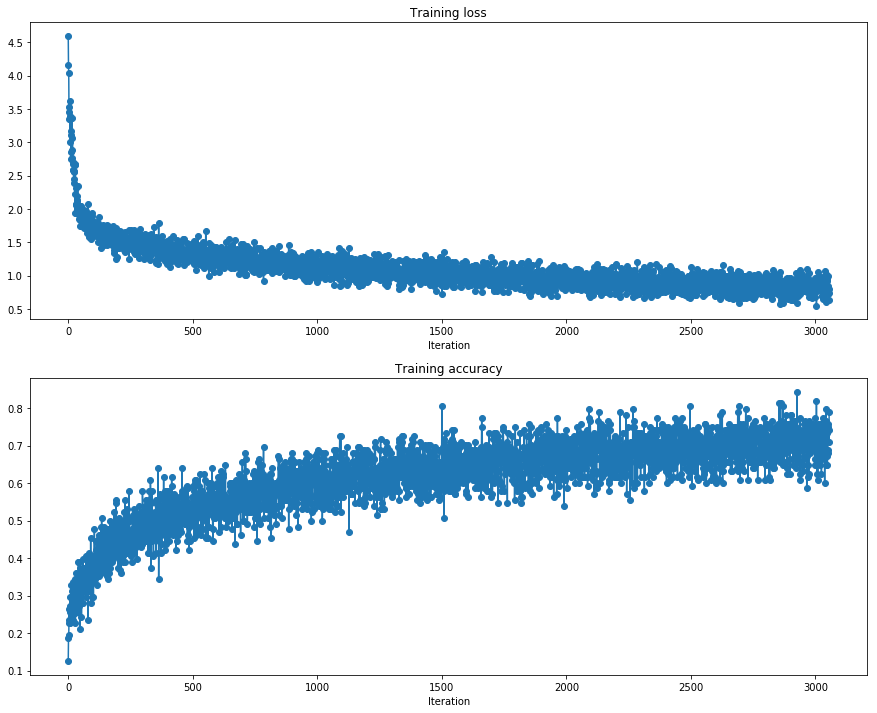

validation for epoch 7
-  epoch 7: validation accuracy = 0.680
train for epoch 8
iteration (3100): loss = 0.838, accuracy = 0.734
iteration (3150): loss = 0.892, accuracy = 0.680
iteration (3200): loss = 0.839, accuracy = 0.695
iteration (3250): loss = 0.962, accuracy = 0.688
iteration (3300): loss = 0.791, accuracy = 0.695
iteration (3350): loss = 0.852, accuracy = 0.695
iteration (3400): loss = 0.648, accuracy = 0.742


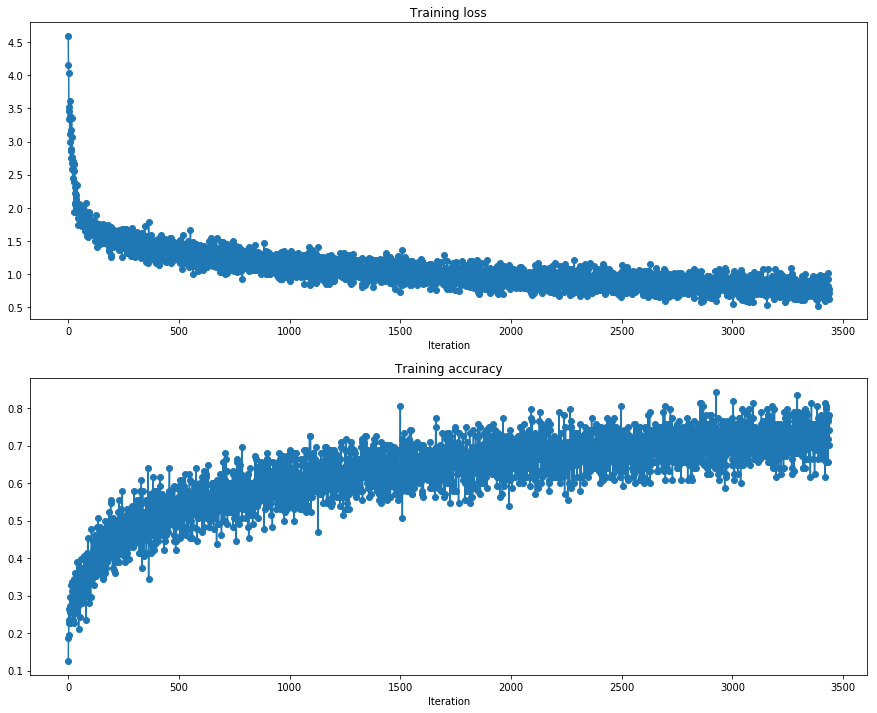

validation for epoch 8
-  epoch 8: validation accuracy = 0.695
train for epoch 9
iteration (3450): loss = 0.754, accuracy = 0.750
iteration (3500): loss = 0.783, accuracy = 0.734
iteration (3550): loss = 0.823, accuracy = 0.727
iteration (3600): loss = 0.804, accuracy = 0.703
iteration (3650): loss = 0.835, accuracy = 0.648
iteration (3700): loss = 0.895, accuracy = 0.648
iteration (3750): loss = 0.687, accuracy = 0.773
iteration (3800): loss = 0.765, accuracy = 0.750


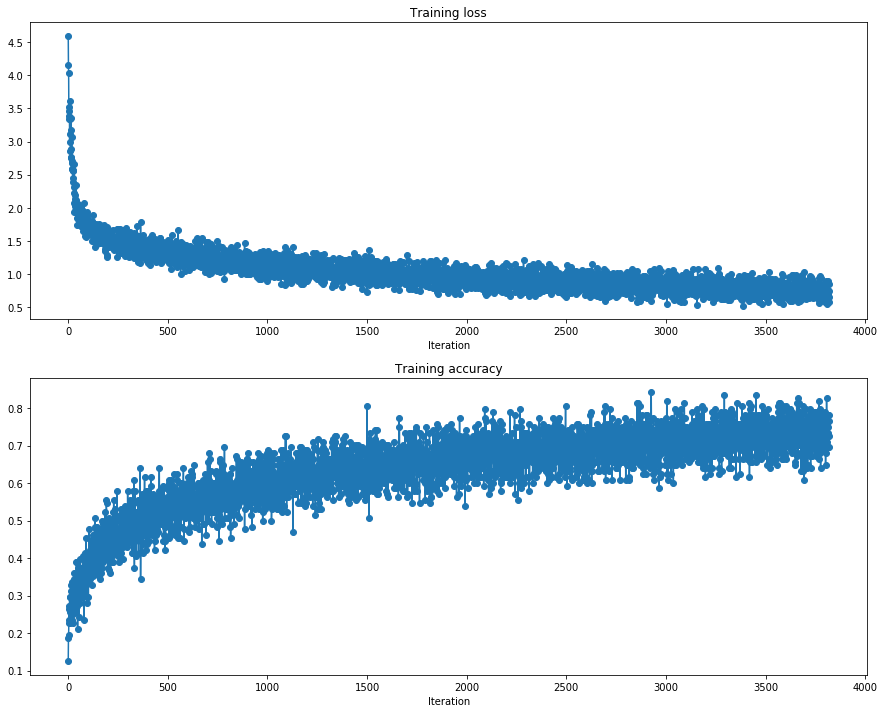

validation for epoch 9
-  epoch 9: validation accuracy = 0.718
train for epoch 10
iteration (3850): loss = 0.797, accuracy = 0.656
iteration (3900): loss = 0.752, accuracy = 0.750
iteration (3950): loss = 0.662, accuracy = 0.727
iteration (4000): loss = 0.698, accuracy = 0.758
iteration (4050): loss = 0.770, accuracy = 0.703
iteration (4100): loss = 0.733, accuracy = 0.734
iteration (4150): loss = 0.580, accuracy = 0.805
iteration (4200): loss = 0.712, accuracy = 0.758


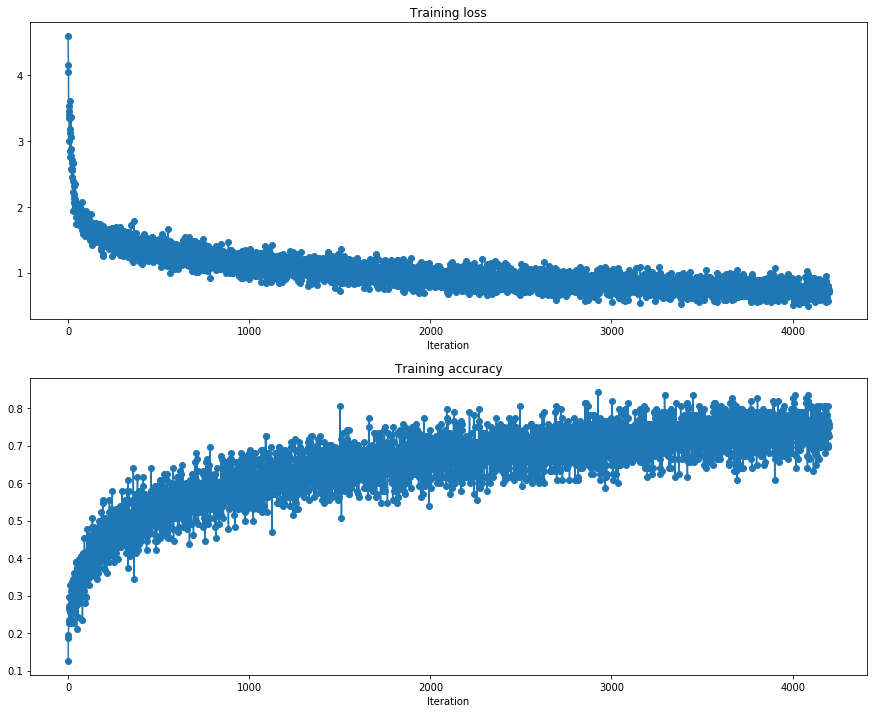

validation for epoch 10
-  epoch 10: validation accuracy = 0.694
train for epoch 11
iteration (4250): loss = 0.621, accuracy = 0.781
iteration (4300): loss = 0.748, accuracy = 0.750
iteration (4350): loss = 0.768, accuracy = 0.695
iteration (4400): loss = 0.615, accuracy = 0.805
iteration (4450): loss = 0.620, accuracy = 0.781
iteration (4500): loss = 0.568, accuracy = 0.797
iteration (4550): loss = 0.825, accuracy = 0.734


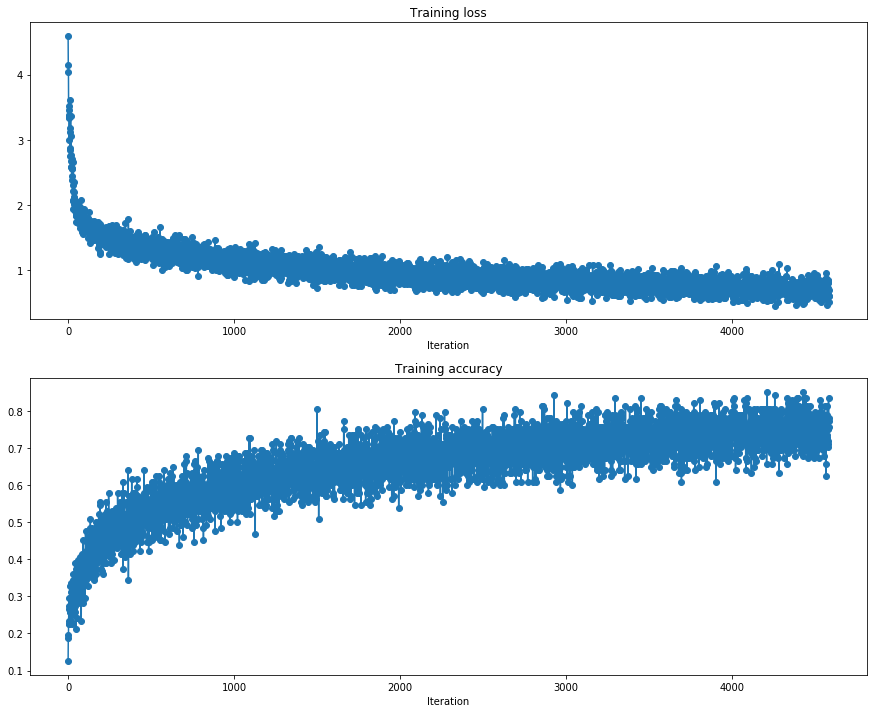

validation for epoch 11
-  epoch 11: validation accuracy = 0.753
train for epoch 12
iteration (4600): loss = 0.615, accuracy = 0.758
iteration (4650): loss = 0.954, accuracy = 0.711
iteration (4700): loss = 0.728, accuracy = 0.695
iteration (4750): loss = 0.626, accuracy = 0.820
iteration (4800): loss = 0.553, accuracy = 0.805
iteration (4850): loss = 0.662, accuracy = 0.812
iteration (4900): loss = 0.777, accuracy = 0.742
iteration (4950): loss = 0.655, accuracy = 0.781


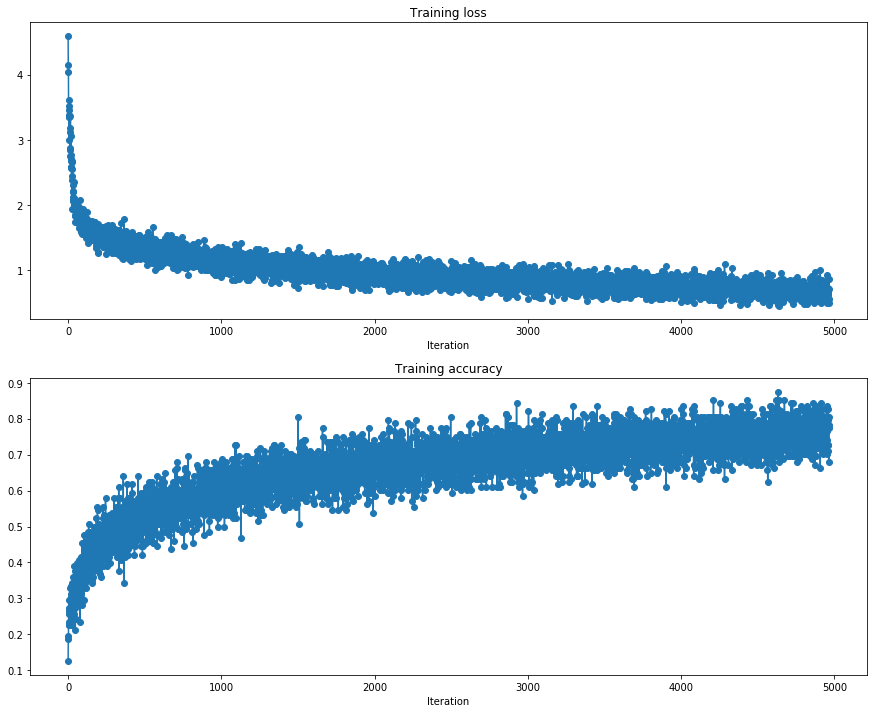

validation for epoch 12
-  epoch 12: validation accuracy = 0.725
train for epoch 13
iteration (5000): loss = 0.618, accuracy = 0.781
iteration (5050): loss = 0.733, accuracy = 0.758
iteration (5100): loss = 0.600, accuracy = 0.766
iteration (5150): loss = 0.629, accuracy = 0.773
iteration (5200): loss = 0.639, accuracy = 0.789
iteration (5250): loss = 0.804, accuracy = 0.711
iteration (5300): loss = 0.554, accuracy = 0.797


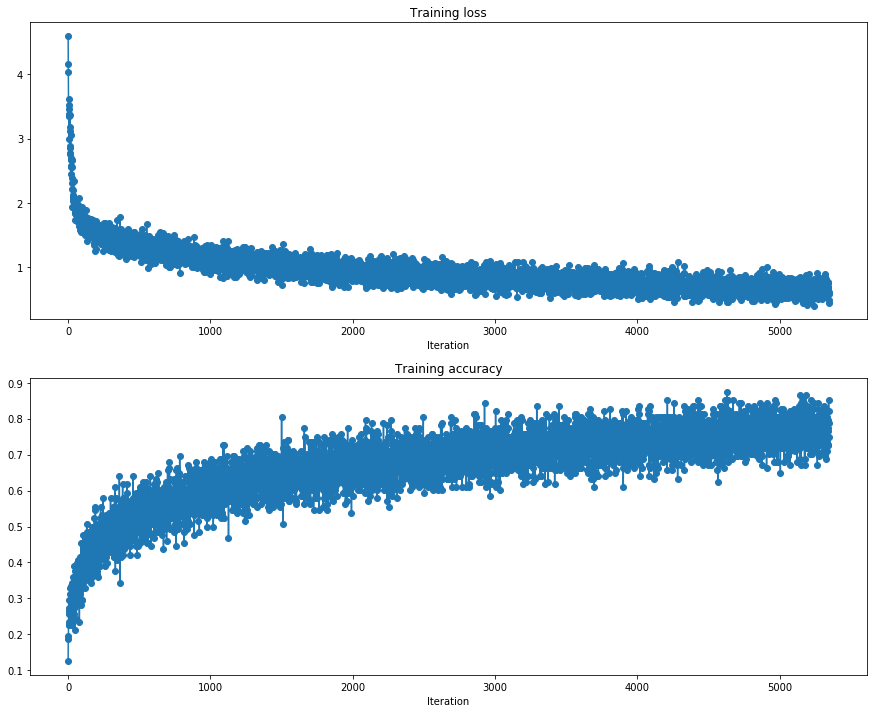

validation for epoch 13
-  epoch 13: validation accuracy = 0.708
train for epoch 14
iteration (5350): loss = 0.749, accuracy = 0.773
iteration (5400): loss = 0.806, accuracy = 0.742
iteration (5450): loss = 0.525, accuracy = 0.812
iteration (5500): loss = 0.717, accuracy = 0.781
iteration (5550): loss = 0.608, accuracy = 0.805
iteration (5600): loss = 0.453, accuracy = 0.820
iteration (5650): loss = 0.577, accuracy = 0.812
iteration (5700): loss = 0.621, accuracy = 0.781


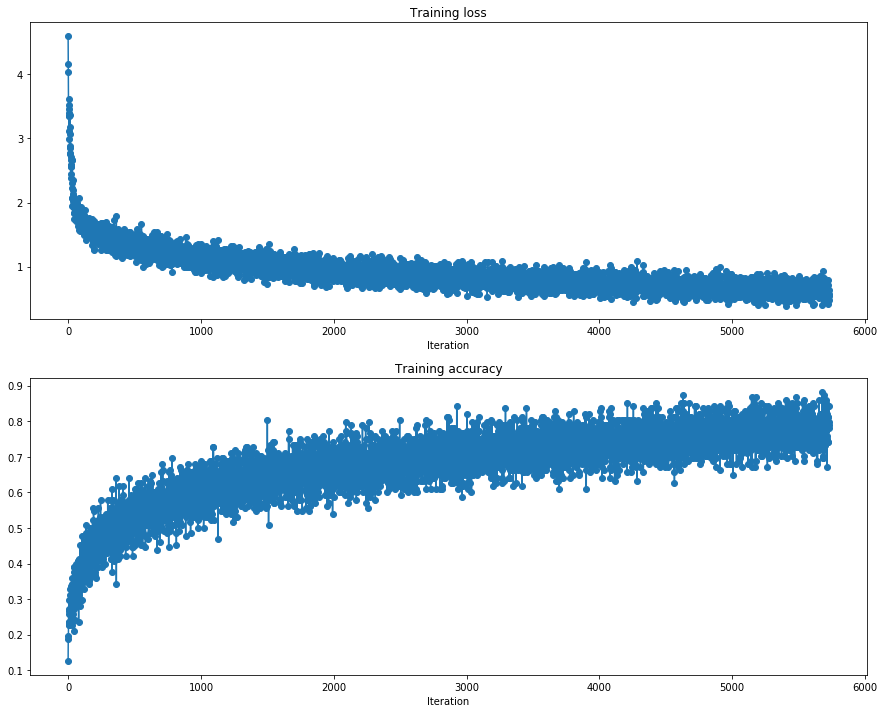

validation for epoch 14
-  epoch 14: validation accuracy = 0.760
train for epoch 15
iteration (5750): loss = 0.444, accuracy = 0.836
iteration (5800): loss = 0.658, accuracy = 0.781
iteration (5850): loss = 0.434, accuracy = 0.852
iteration (5900): loss = 0.660, accuracy = 0.812
iteration (5950): loss = 0.524, accuracy = 0.820
iteration (6000): loss = 0.669, accuracy = 0.719
iteration (6050): loss = 0.554, accuracy = 0.789
iteration (6100): loss = 0.578, accuracy = 0.805


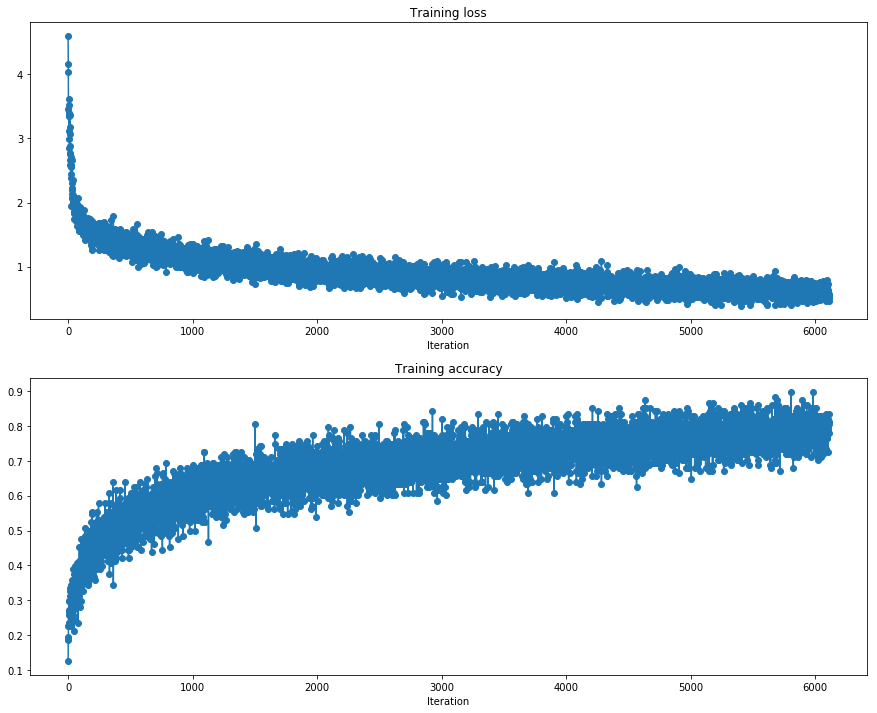

validation for epoch 15
-  epoch 15: validation accuracy = 0.749
train for epoch 16
iteration (6150): loss = 0.640, accuracy = 0.781
iteration (6200): loss = 0.472, accuracy = 0.828
iteration (6250): loss = 0.673, accuracy = 0.789
iteration (6300): loss = 0.596, accuracy = 0.789
iteration (6350): loss = 0.739, accuracy = 0.797
iteration (6400): loss = 0.718, accuracy = 0.742
iteration (6450): loss = 0.560, accuracy = 0.773


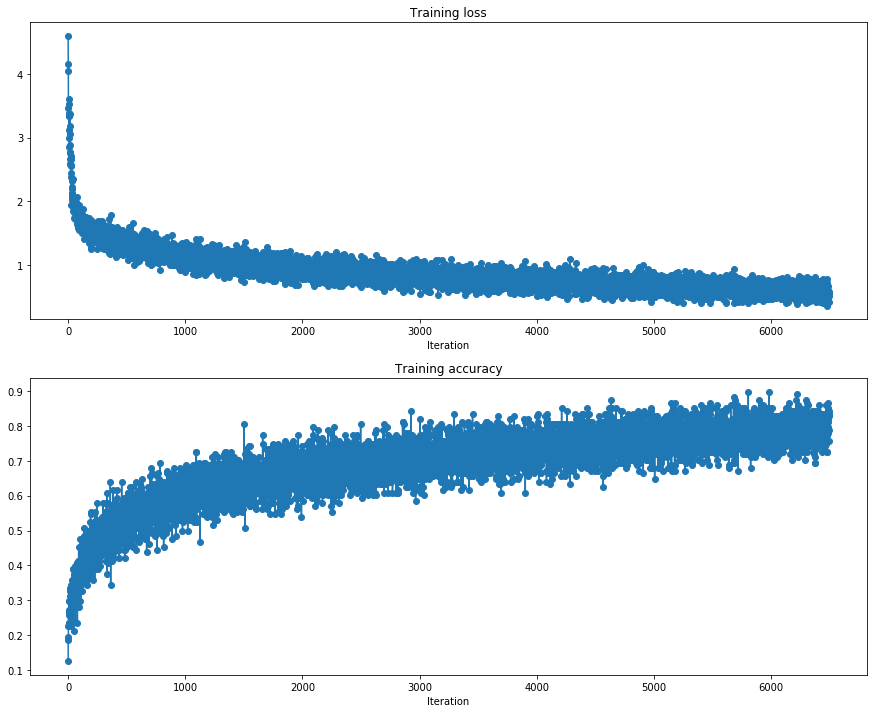

validation for epoch 16
-  epoch 16: validation accuracy = 0.760
train for epoch 17
iteration (6500): loss = 0.624, accuracy = 0.766
iteration (6550): loss = 0.614, accuracy = 0.781
iteration (6600): loss = 0.603, accuracy = 0.805
iteration (6650): loss = 0.518, accuracy = 0.820
iteration (6700): loss = 0.530, accuracy = 0.828
iteration (6750): loss = 0.689, accuracy = 0.805
iteration (6800): loss = 0.558, accuracy = 0.797
iteration (6850): loss = 0.519, accuracy = 0.820


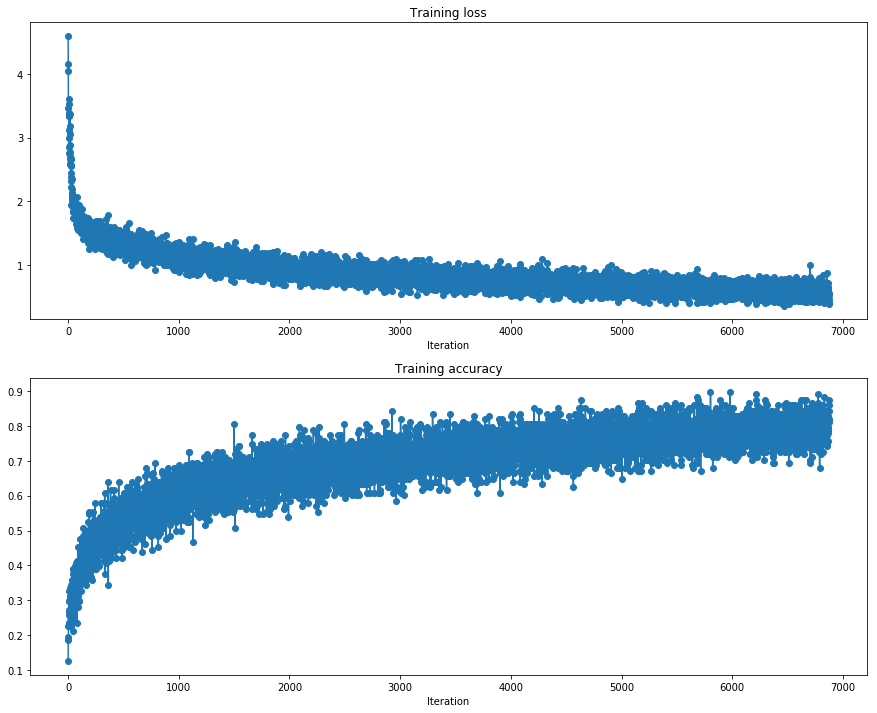

validation for epoch 17
-  epoch 17: validation accuracy = 0.779
train for epoch 18
iteration (6900): loss = 0.589, accuracy = 0.766
iteration (6950): loss = 0.537, accuracy = 0.820
iteration (7000): loss = 0.680, accuracy = 0.773
iteration (7050): loss = 0.731, accuracy = 0.750
iteration (7100): loss = 0.693, accuracy = 0.758
iteration (7150): loss = 0.640, accuracy = 0.781
iteration (7200): loss = 0.678, accuracy = 0.758
iteration (7250): loss = 0.631, accuracy = 0.789


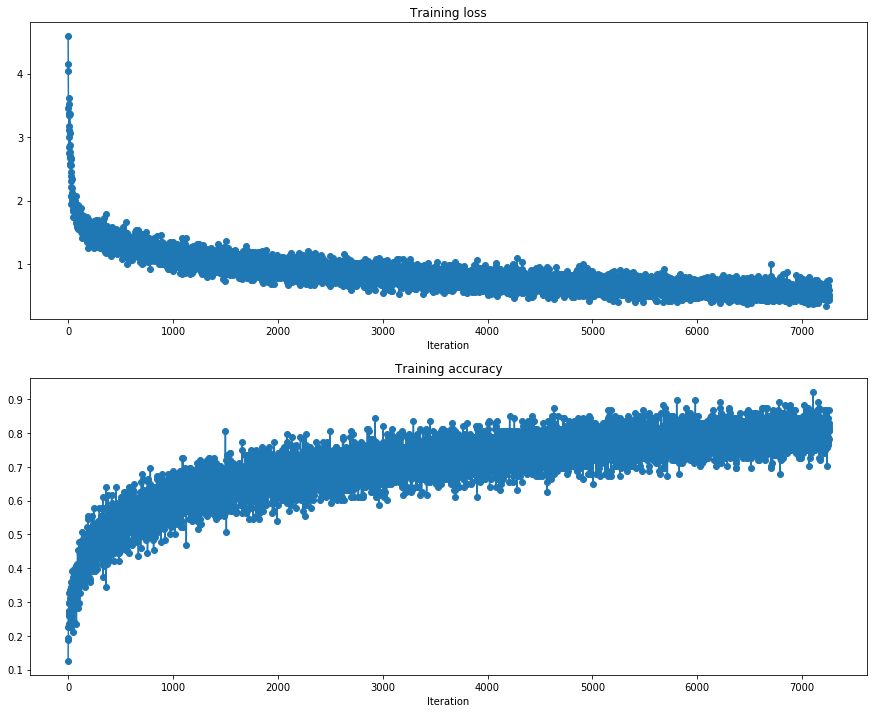

validation for epoch 18
-  epoch 18: validation accuracy = 0.750
train for epoch 19
iteration (7300): loss = 0.664, accuracy = 0.766
iteration (7350): loss = 0.537, accuracy = 0.836
iteration (7400): loss = 0.708, accuracy = 0.727
iteration (7450): loss = 0.463, accuracy = 0.836
iteration (7500): loss = 0.566, accuracy = 0.766
iteration (7550): loss = 0.572, accuracy = 0.805
iteration (7600): loss = 0.479, accuracy = 0.797


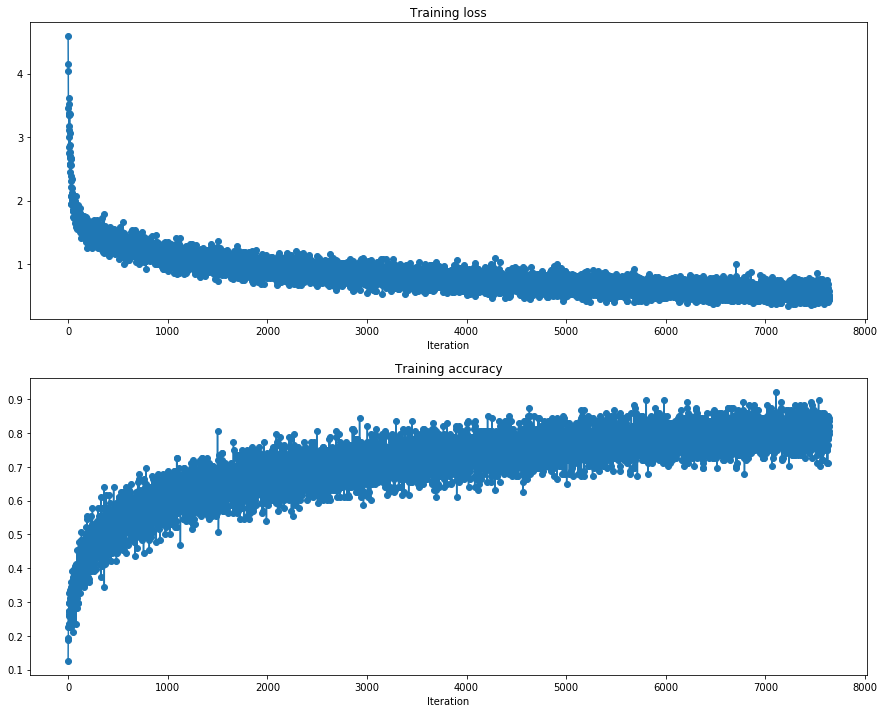

validation for epoch 19
-  epoch 19: validation accuracy = 0.794
train for epoch 20
iteration (7650): loss = 0.569, accuracy = 0.812
iteration (7700): loss = 0.468, accuracy = 0.852
iteration (7750): loss = 0.530, accuracy = 0.844
iteration (7800): loss = 0.599, accuracy = 0.797
iteration (7850): loss = 0.471, accuracy = 0.828
iteration (7900): loss = 0.519, accuracy = 0.812
iteration (7950): loss = 0.670, accuracy = 0.758
iteration (8000): loss = 0.445, accuracy = 0.844


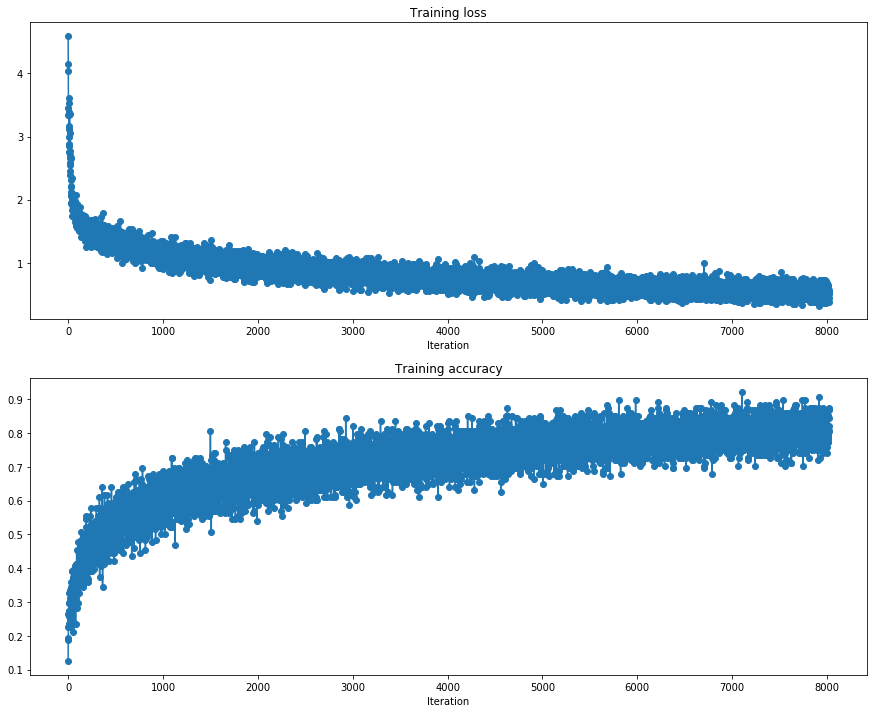

validation for epoch 20
-  epoch 20: validation accuracy = 0.770
train for epoch 21
iteration (8050): loss = 0.432, accuracy = 0.852
iteration (8100): loss = 0.435, accuracy = 0.844
iteration (8150): loss = 0.530, accuracy = 0.820
iteration (8200): loss = 0.558, accuracy = 0.773
iteration (8250): loss = 0.438, accuracy = 0.859
iteration (8300): loss = 0.357, accuracy = 0.875
iteration (8350): loss = 0.552, accuracy = 0.820
iteration (8400): loss = 0.379, accuracy = 0.875


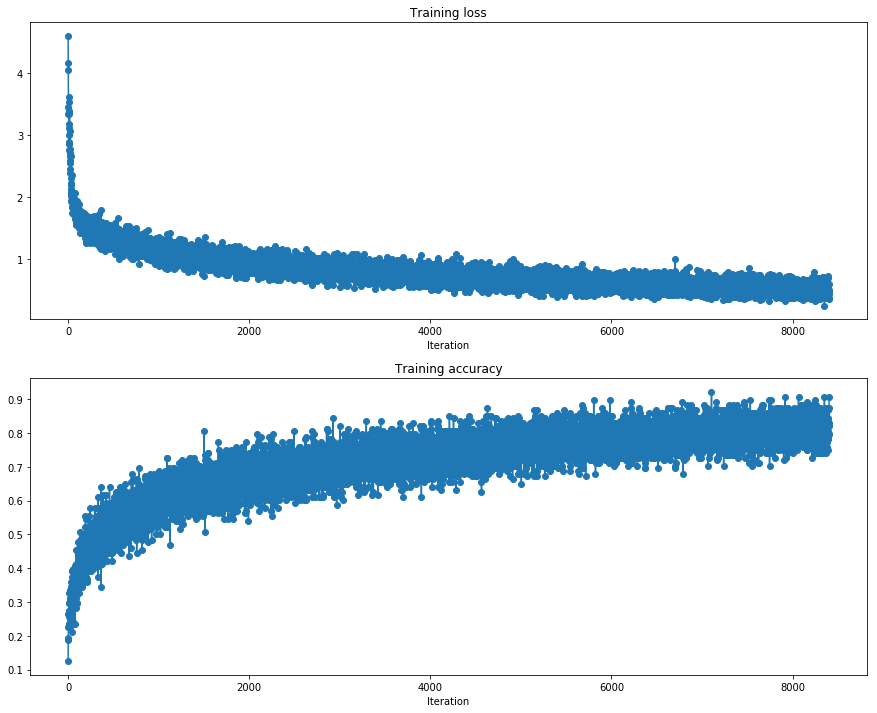

validation for epoch 21
-  epoch 21: validation accuracy = 0.759
train for epoch 22
iteration (8450): loss = 0.364, accuracy = 0.859
iteration (8500): loss = 0.572, accuracy = 0.820
iteration (8550): loss = 0.355, accuracy = 0.875
iteration (8600): loss = 0.583, accuracy = 0.805
iteration (8650): loss = 0.607, accuracy = 0.773
iteration (8700): loss = 0.560, accuracy = 0.805
iteration (8750): loss = 0.470, accuracy = 0.805


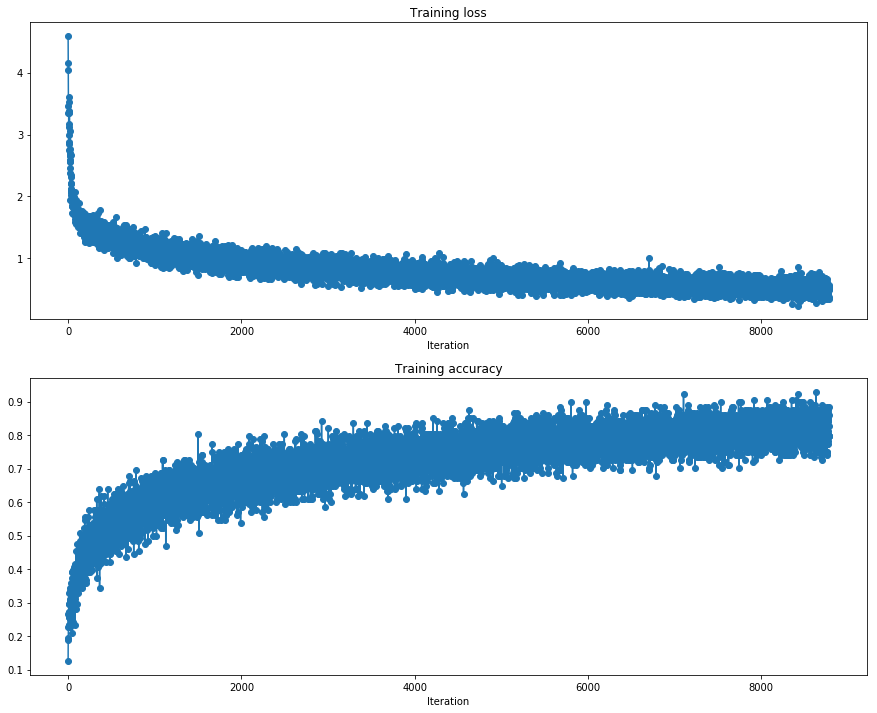

validation for epoch 22
-  epoch 22: validation accuracy = 0.765
train for epoch 23
iteration (8800): loss = 0.379, accuracy = 0.883
iteration (8850): loss = 0.524, accuracy = 0.805
iteration (8900): loss = 0.478, accuracy = 0.805
iteration (8950): loss = 0.324, accuracy = 0.891
iteration (9000): loss = 0.441, accuracy = 0.812
iteration (9050): loss = 0.502, accuracy = 0.820
iteration (9100): loss = 0.488, accuracy = 0.812
iteration (9150): loss = 0.485, accuracy = 0.805


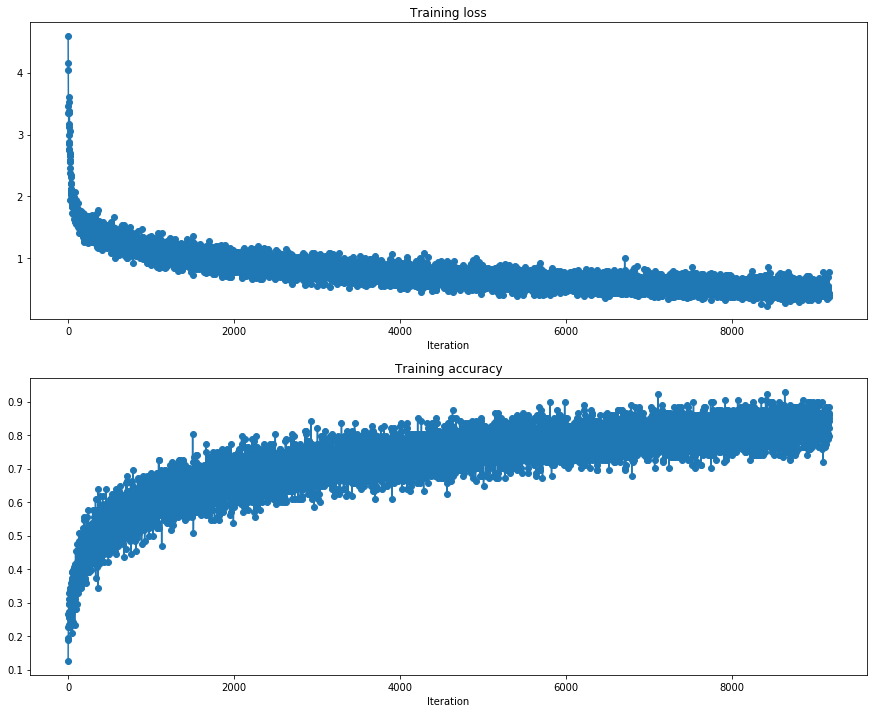

validation for epoch 23
-  epoch 23: validation accuracy = 0.775
train for epoch 24
iteration (9200): loss = 0.519, accuracy = 0.820
iteration (9250): loss = 0.427, accuracy = 0.883
iteration (9300): loss = 0.394, accuracy = 0.852
iteration (9350): loss = 0.446, accuracy = 0.828
iteration (9400): loss = 0.434, accuracy = 0.844
iteration (9450): loss = 0.585, accuracy = 0.812
iteration (9500): loss = 0.600, accuracy = 0.734


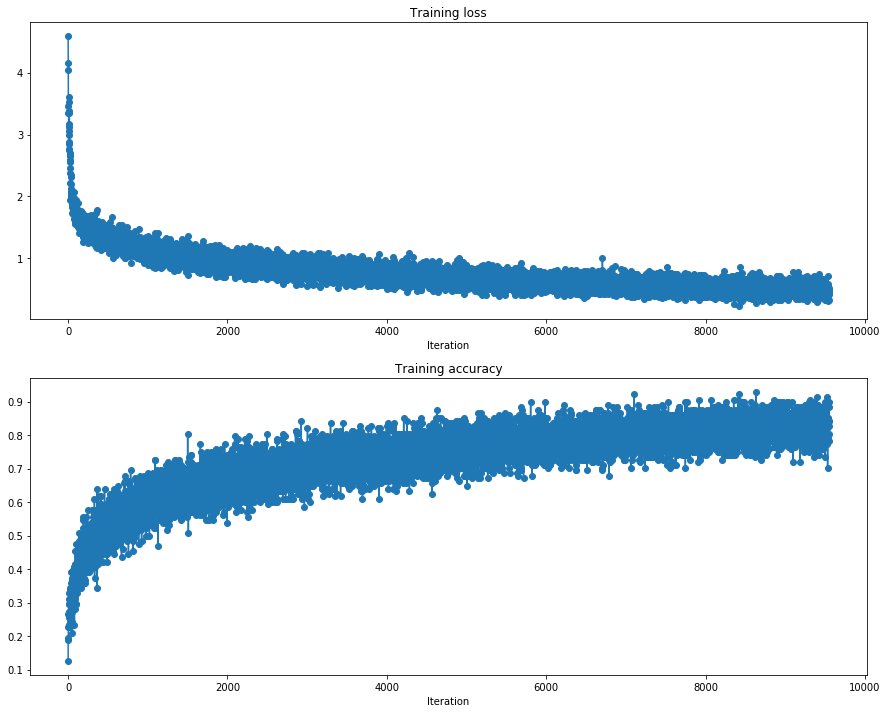

validation for epoch 24
-  epoch 24: validation accuracy = 0.780
train for epoch 25
iteration (9550): loss = 0.437, accuracy = 0.883
iteration (9600): loss = 0.556, accuracy = 0.773
iteration (9650): loss = 0.520, accuracy = 0.820
iteration (9700): loss = 0.620, accuracy = 0.766
iteration (9750): loss = 0.599, accuracy = 0.836
iteration (9800): loss = 0.427, accuracy = 0.859
iteration (9850): loss = 0.442, accuracy = 0.812
iteration (9900): loss = 0.518, accuracy = 0.789


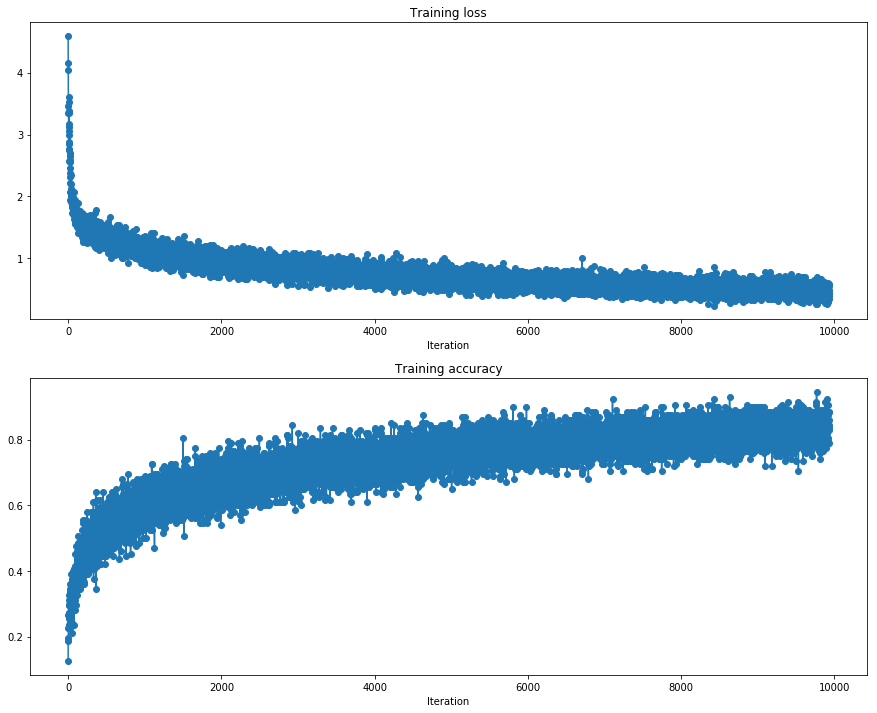

validation for epoch 25
-  epoch 25: validation accuracy = 0.780
train for epoch 26
iteration (9950): loss = 0.370, accuracy = 0.852
iteration (10000): loss = 0.421, accuracy = 0.828
iteration (10050): loss = 0.539, accuracy = 0.820
iteration (10100): loss = 0.453, accuracy = 0.859
iteration (10150): loss = 0.415, accuracy = 0.859
iteration (10200): loss = 0.482, accuracy = 0.812
iteration (10250): loss = 0.470, accuracy = 0.844
iteration (10300): loss = 0.369, accuracy = 0.875


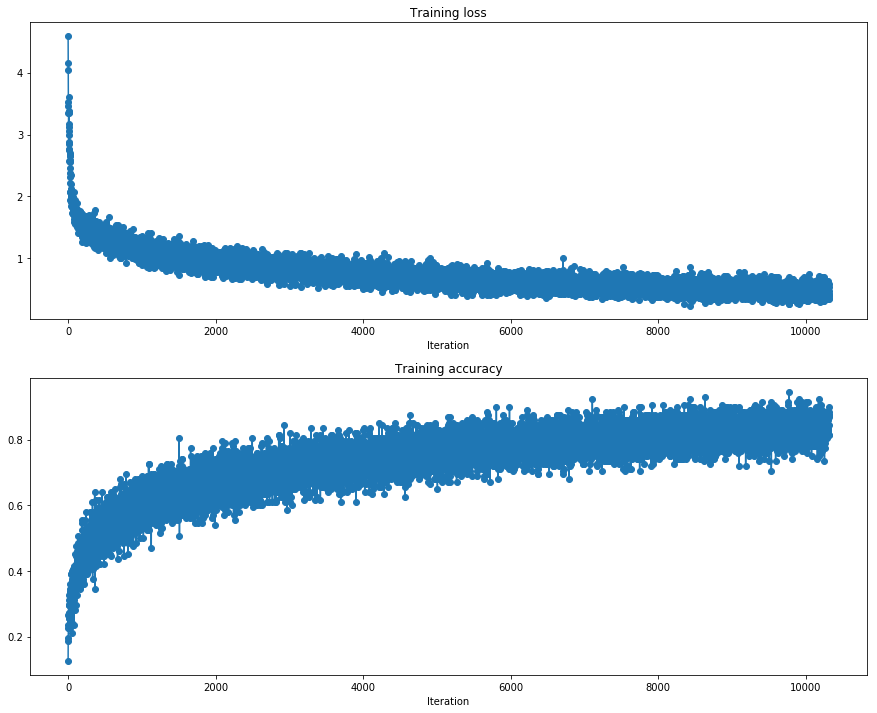

validation for epoch 26
-  epoch 26: validation accuracy = 0.782
train for epoch 27
iteration (10350): loss = 0.375, accuracy = 0.859
iteration (10400): loss = 0.633, accuracy = 0.766
iteration (10450): loss = 0.396, accuracy = 0.820
iteration (10500): loss = 0.390, accuracy = 0.875
iteration (10550): loss = 0.497, accuracy = 0.836
iteration (10600): loss = 0.526, accuracy = 0.828
iteration (10650): loss = 0.378, accuracy = 0.844


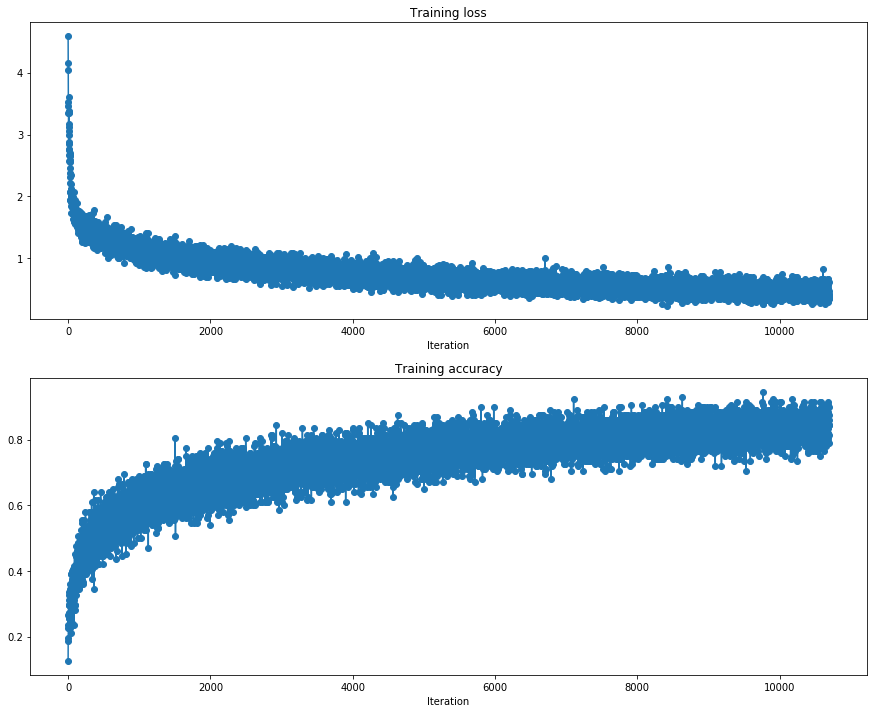

validation for epoch 27
-  epoch 27: validation accuracy = 0.792
train for epoch 28
iteration (10700): loss = 0.402, accuracy = 0.852
iteration (10750): loss = 0.346, accuracy = 0.852
iteration (10800): loss = 0.451, accuracy = 0.836
iteration (10850): loss = 0.524, accuracy = 0.844
iteration (10900): loss = 0.383, accuracy = 0.875
iteration (10950): loss = 0.376, accuracy = 0.852
iteration (11000): loss = 0.393, accuracy = 0.859
iteration (11050): loss = 0.332, accuracy = 0.898


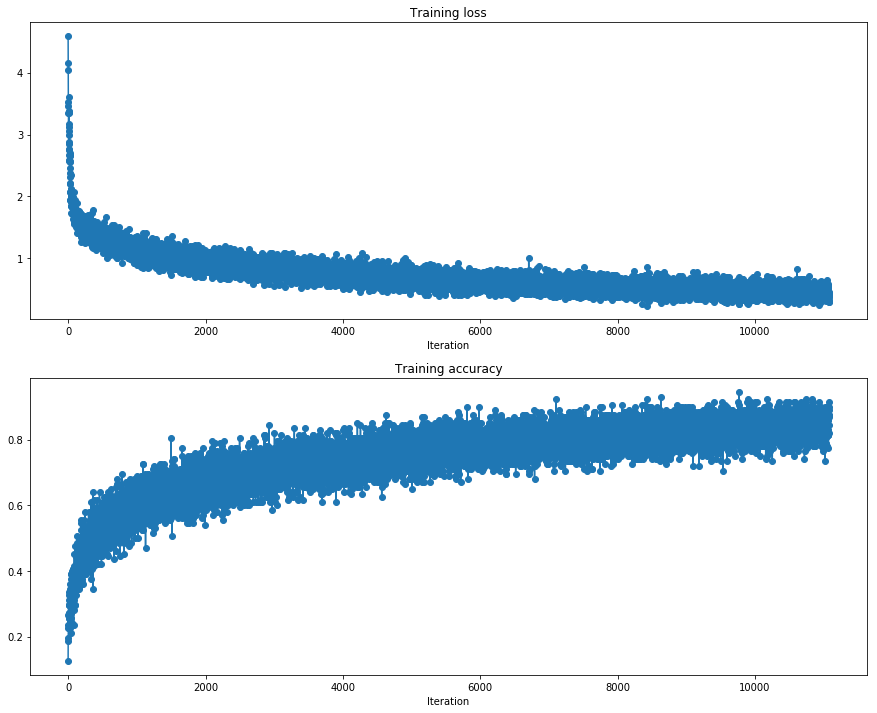

validation for epoch 28
-  epoch 28: validation accuracy = 0.791
train for epoch 29
iteration (11100): loss = 0.355, accuracy = 0.867
iteration (11150): loss = 0.388, accuracy = 0.844
iteration (11200): loss = 0.483, accuracy = 0.844
iteration (11250): loss = 0.436, accuracy = 0.836
iteration (11300): loss = 0.532, accuracy = 0.773
iteration (11350): loss = 0.475, accuracy = 0.828
iteration (11400): loss = 0.428, accuracy = 0.867
iteration (11450): loss = 0.429, accuracy = 0.867


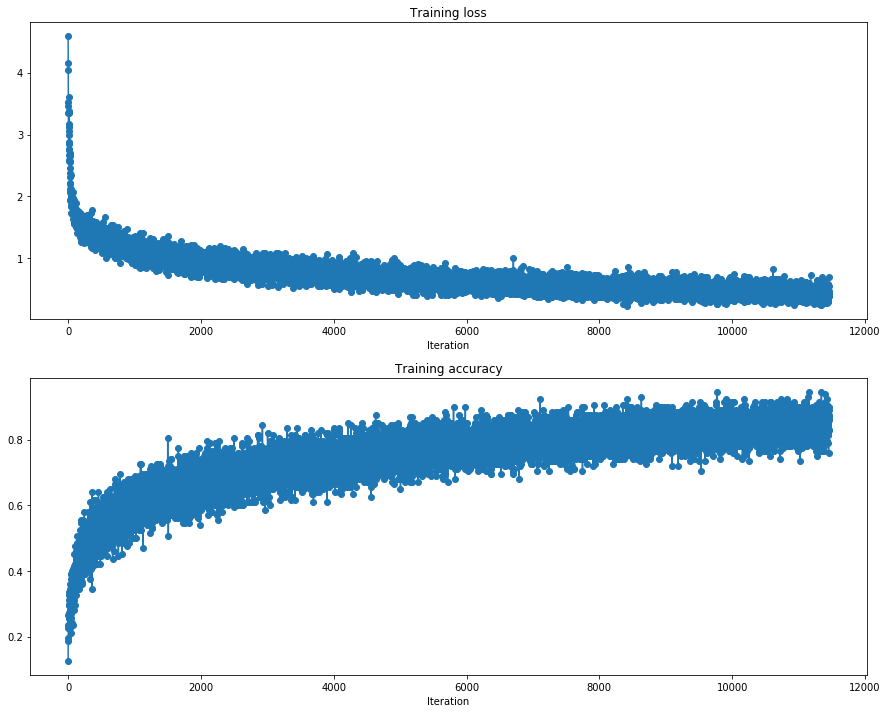

validation for epoch 29
-  epoch 29: validation accuracy = 0.778
***** test accuracy: 0.771
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [62]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = X_train
X_val_ = X_val
X_test_ = X_test
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [63]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
scope 1: (?, 16, 16, 32)
scope 2: (?, 8, 8, 64)
flat layer: (?, 4096)
scope 3: (?, 512)
scope 4: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt


INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
